## Notebook 01 — Asset-Side Data Construction (TVL Proxy)

This notebook builds a reproducible data pipeline to construct an
asset-side time series for an RWA-backed stablecoin system.

Because the true reserve balance sheet of on-chain RWA protocols is not
fully observable, I use protocol-level TVL data from DeFiLlama as a
transparent and verifiable proxy for asset scale.

The workflow consists of:

	1.	Querying all available DeFi protocols from DeFiLlama
	2.	Identifying candidate protocols relevant to RWA-backed stablecoins (e.g., Spark, Sky, Maker)
	3.	Pulling historical TVL data for the selected protocol slug
	4.	Transforming the data into a clean time series suitable for  downstream solvency and liquidity stress testing
	5.	Visualizing and optionally persisting the asset proxy for later analysis

The resulting asset time series serves as the asset-side input for all
subsequent risk stress tests in this project.

In [ ]:
import requests, pandas as pd

# Query the full universe of DeFi protocols from DeFiLlama.
# This defines the searchable space from which we identify
# candidate protocols relevant to RWA-backed stablecoins.

url = "https://api.llama.fi/protocols"
protocols = requests.get(url).json()

# Convert raw JSON into a DataFrame for easier filtering
protocols_df = pd.DataFrame(protocols)

# Inspect available columns (name, slug, tvl, category, etc.)
protocols_df.head()


,id,name,address,symbol,url,description,chain,logo,audits,gecko_id,...,pool2,tags,stablecoins,language,deadUrl,warningBanners,excludeTvlFromParent,forkedFrom,deadFrom,rugged
0,2269,Binance CEX,None,-,https://www.binance.com,Binance is a cryptocurrency exchange which is ...,Multi-Chain,https://icons.llama.fi/binance-cex.jpg,0,binancecoin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1599,Aave V3,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9,AAVE,https://aave.com,"Earn interest, borrow assets, and build applic...",Multi-Chain,https://icons.llama.fi/aave-v3.png,2,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,182,Lido,0x5a98fcbea516cf06857215779fd812ca3bef1b32,LDO,https://lido.fi/,Liquid staking for Ethereum and Polygon. Daily...,Multi-Chain,https://icons.llama.fi/lido.png,2,lido-dao,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2272,OKX,None,-,https://www.okx.com,"OKX, formerly known as OKEx, is a Seychelles-b...",Multi-Chain,https://icons.llama.fi/okx.jpg,0,okb,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2275,Bitfinex,None,-,https://www.bitfinex.com,Bitfinex facilitates a graphical trading exper...,Multi-Chain,https://icons.llama.fi/bitfinex.png,0,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Narrow the protocol universe to candidates associated
# with stablecoins and RWA-related asset pools.
# This avoids arbitrary protocol selection.


keywords = ["spark", "maker", "sky"]

mask = protocols_df["slug"].str.contains(
    "|".join(keywords), case=False, na=False
)

candidates = protocols_df.loc[mask, ["name", "slug", "tvl"]]
candidates

,name,slug,tvl
19,Sky Lending,sky-lending,5.548823e+09
28,SparkLend,sparklend,3.453322e+09
45,Spark Liquidity Layer,spark-liquidity-layer,1.823592e+09
72,Spark Savings,spark-savings,9.945390e+08
316,Sky RWA,sky-rwa,8.729375e+07
440,SparkDEX V3.1,sparkdex-v3.1,4.418476e+07
759,Swaap Maker V2,swaap-maker-v2,1.074202e+07
1172,SparkDEX Perps,sparkdex-perps,2.612516e+06
2153,SparkleX,sparklex,2.471491e+05
2263,Sparkswap,sparkswap,1.885213e+05


In [ ]:
# Pull historical TVL for the selected protocol.
# This time series serves as a proxy for the asset side of an RWA-backed stablecoin balance sheet.

slug = "spark"  # chosen protocol
data = requests.get(f"https://api.llama.fi/protocol/{slug}").json()

tvl_hist = pd.DataFrame(data["tvl"])
tvl_hist["date"] = pd.to_datetime(tvl_hist["date"], unit="s")
tvl_hist = tvl_hist.rename(columns={"totalLiquidityUSD": "assets_proxy_usd"})

tvl_hist.tail()

,date,assets_proxy_usd
1003,2026-01-28 00:00:00,6.017335e+09
1004,2026-01-29 00:00:00,6.014554e+09
1005,2026-01-30 00:00:00,6.217330e+09
1006,2026-01-31 00:00:00,6.049899e+09
1007,2026-01-31 02:57:59,6.045493e+09


In [ ]:
import requests
import pandas as pd

def fetch_json(url: str, *, timeout: int = 30, verbose: bool = True):
    """
    Fetch JSON from a URL with lightweight diagnostics (API health check).
    Since we rely on public DeFi endpoints (e.g., DeFiLlama).
    These APIs can occasionally:
      - return non-JSON payloads (HTML error pages, Cloudflare blocks),
      - return empty / truncated responses,
      - respond with rate-limit or server errors.
    """

    # Use a browser-like User-Agent to reduce the chance of being blocked by some CDNs.
    headers = {"User-Agent": "Mozilla/5.0"}

    r = requests.get(url, timeout=timeout, headers=headers)

    # Print diagnostics
    if verbose:
        ct = r.headers.get("content-type", "")
        preview = r.text[:200].replace("\n", " ")
        print(f"[fetch_json] GET {url}")
        print(f"  status       : {r.status_code}")
        print(f"  content-type : {ct}")
        print(f"  preview      : {preview}")

    # Raise for HTTP errors early (4xx/5xx)
    r.raise_for_status()

    # Parse JSON with a clear error message if parsing fails
    try:
        return r.json()
    except ValueError as e:
        # If this happens, the endpoint likely returned HTML or malformed JSON.
        raise ValueError(
            f"Response was not valid JSON. "
            f"status={r.status_code}, content-type={r.headers.get('content-type')}"
        ) from e

In [ ]:
protocols = fetch_json("https://api.llama.fi/protocols")
df = pd.DataFrame(protocols)
df[["name","slug","category","tvl"]].head()

[fetch_json] GET https://api.llama.fi/protocols
  status       : 200
  content-type : application/json
  preview      : [{"id":"2269","name":"Binance CEX","address":null,"symbol":"-","url":"https://www.binance.com","description":"Binance is a cryptocurrency exchange which is the largest exchange in the world in terms o


,name,slug,category,tvl
0,Binance CEX,binance-cex,CEX,1.597703e+11
1,Aave V3,aave-v3,Lending,3.151404e+10
2,Lido,lido,Liquid Staking,2.593261e+10
3,OKX,okx,CEX,2.106396e+10
4,Bitfinex,bitfinex,CEX,1.985331e+10


In [ ]:
df["category"].value_counts().head(20)

,count
category,
Dexs,1898
Yield,612
Lending,581
Derivatives,391
Liquid Staking,276
Farm,228
CDP,216
Yield Aggregator,200
Launchpad,154


In [ ]:
# Filter protocol universe to RWA / stablecoin-relevant candidates
# (Spark, Sky, Maker) and rank by current TVL for scale comparison
cand = df[df["name"].str.contains("spark|sky|maker", case=False, na=False)][
    ["name","slug","category","tvl"]
].sort_values("tvl", ascending=False)

cand.head(30)

,name,slug,category,tvl
19,Sky Lending,sky-lending,CDP,5.548823e+09
28,SparkLend,sparklend,Lending,3.453322e+09
45,Spark Liquidity Layer,spark-liquidity-layer,Onchain Capital Allocator,1.823592e+09
72,Spark Savings,spark-savings,Yield,9.945390e+08
316,Sky RWA,sky-rwa,RWA,8.729375e+07
440,SparkDEX V3.1,sparkdex-v3.1,Dexs,4.418476e+07
759,Swaap Maker V2,swaap-maker-v2,Dexs,1.074202e+07
1172,SparkDEX Perps,sparkdex-perps,Derivatives,2.612516e+06
2153,SparkleX,sparklex,Yield,2.471491e+05
2263,Sparkswap,sparkswap,Farm,1.885213e+05


In [ ]:
# Select protocol case study and pull historical TVL
# TVL is used as a transparent proxy for asset-side scale
slug = "spark"
data = fetch_json(f"https://api.llama.fi/protocol/{slug}")

tvl = pd.DataFrame(data["tvl"])
tvl["date"] = pd.to_datetime(tvl["date"], unit="s")
tvl = tvl.rename(columns={"totalLiquidityUSD":"assets_proxy_usd"})
tvl.tail()

[fetch_json] GET https://api.llama.fi/protocol/spark
  status       : 200
  content-type : application/json
  preview      : {"id":"parent#spark","name":"Spark","url":"https://app.spark.fi/points/KNQ5HD","referralUrl":"https://app.spark.fi/points/KNQ5HD","description":"Spark is an onchain capital allocator that borrows from


,date,assets_proxy_usd
1003,2026-01-28 00:00:00,6.017335e+09
1004,2026-01-29 00:00:00,6.014554e+09
1005,2026-01-30 00:00:00,6.217330e+09
1006,2026-01-31 00:00:00,6.049899e+09
1007,2026-01-31 02:57:59,6.045493e+09


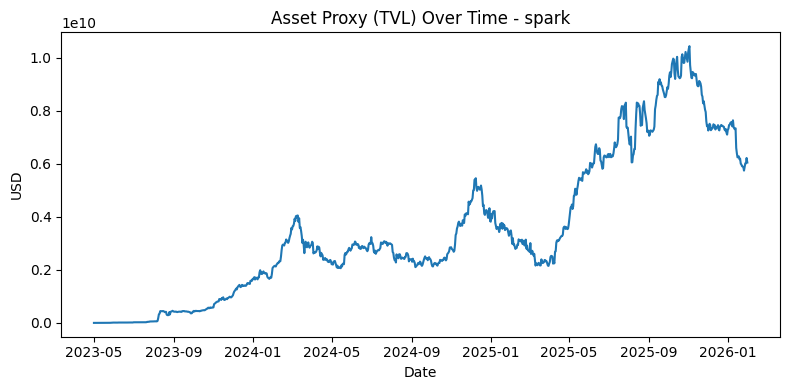

In [ ]:
import matplotlib.pyplot as plt

# Plot the asset proxy over time (TVL as proxy)
plt.figure(figsize=(8,4))
plt.plot(tvl["date"], tvl["assets_proxy_usd"])
plt.title(f"Asset Proxy (TVL) Over Time - {slug}")
plt.xlabel("Date")
plt.ylabel("USD")
plt.tight_layout()
plt.show()

In [ ]:
import os

os.makedirs("data", exist_ok=True)
out_path = "data/spark_assets_proxy.csv"
tvl.to_csv(out_path, index=False)

print("Saved:", os.path.abspath(out_path))

from google.colab import files
files.download(out_path)

Saved: /content/data/spark_assets_proxy.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>